# Channel Head Coupling Analysis - Experiment Template

This notebook provides a clean template for running analysis experiments with different parameters.

**Key features:**
- All experiment parameters defined in one cell
- Outputs automatically organized by experiment name/threshold
- Easy to duplicate for new experiments

## How to use:
1. **Duplicate this notebook** for each experiment (e.g., `experiment_th500.ipynb`)
2. **Modify the parameters** in the "Experiment Configuration" cell below
3. **Run all cells** to execute the analysis
4. Results are saved to `data/outputs/experiments/{EXPERIMENT_NAME}/`

---
## Experiment Configuration

**Modify these parameters for your experiment:**

In [2]:
# ============================================================================
# EXPERIMENT PARAMETERS - MODIFY THESE FOR YOUR EXPERIMENT
# ============================================================================

# Experiment identification
EXPERIMENT_NAME = "th350_test"  # Unique name for this experiment
EXPERIMENT_NOTES = "Testing higher stream threshold (350 vs default 145)"

# Stream extraction threshold (default in paper: 145)
# Higher = fewer, larger streams; Lower = more, smaller streams
STREAM_THRESHOLD = 350

# Basins to analyze (set to None for all 18 basins)
# Examples:
#   BASINS_TO_RUN = None  # All 18 basins
#   BASINS_TO_RUN = ["inyo", "humboldt"]  # Just these two
#   BASINS_TO_RUN = ["inyo"]  # Single basin for quick test
BASINS_TO_RUN = None  # Quick test set

# Limit outlets per basin (None = all outlets, useful for quick tests)
MAX_OUTLETS_PER_BASIN = None

# Connectivity for coupling detection (4 or 8)
# 8 = include diagonal neighbors (more sensitive)
# 4 = only cardinal directions (more conservative)
CONNECTIVITY = 8

# ============================================================================
print(f"Experiment: {EXPERIMENT_NAME}")
print(f"Notes: {EXPERIMENT_NOTES}")
print(f"Stream threshold: {STREAM_THRESHOLD}")
print(f"Basins: {BASINS_TO_RUN or 'All 18'}")
print(f"Max outlets per basin: {MAX_OUTLETS_PER_BASIN or 'All'}")
print(f"Connectivity: {CONNECTIVITY}")

Experiment: th350_test
Notes: Testing higher stream threshold (350 vs default 145)
Stream threshold: 350
Basins: All 18
Max outlets per basin: All
Connectivity: 8


---
## Setup and Imports

In [3]:
import sys
import pathlib
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import topotoolbox as tt3

# Add project root so "channel_heads" package is visible
project_root = pathlib.Path("/Users/guypi/Projects/channel-heads")
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Core analysis imports
from channel_heads import (
    CouplingAnalyzer,
    first_meet_pairs_for_outlet,
    outlet_node_ids_from_streampoi,
    # Lengthwise asymmetry
    LengthwiseAsymmetryAnalyzer,
    compute_asymmetry_statistics,
    merge_coupling_and_asymmetry,
    # Basin configuration
    get_z_th,
    get_basin_config,
    get_reference_delta_L,
    BASIN_CONFIG,
    # Path management
    CROPPED_DEMS_DIR,
    get_experiment_output_dir,
)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
%matplotlib inline

# Create output directory for this experiment
OUTPUT_DIR = get_experiment_output_dir(EXPERIMENT_NAME)
print(f"\nOutput directory: {OUTPUT_DIR}")
print("Setup complete!")


Output directory: /Users/guypi/Projects/channel-heads/data/outputs/experiments/th350_test
Setup complete!


---
## Basin Configuration

In [4]:
# All 18 basins from Goren & Shelef (2024)
ALL_BASINS = {
    "inyo": {"dem_path": CROPPED_DEMS_DIR / "Inyo_strm_crop.tif", "paper_name": "inyo"},
    "humboldt": {"dem_path": CROPPED_DEMS_DIR / "Humboldt_strm_crop.tif", "paper_name": "humboldt"},
    "calnalpine": {"dem_path": CROPPED_DEMS_DIR / "CalnAlpine_strm_crop.tif", "paper_name": "clanalpine"},
    "daqing": {"dem_path": CROPPED_DEMS_DIR / "Daqing_strm_crop.tif", "paper_name": "daqing"},
    "kammanasie": {"dem_path": CROPPED_DEMS_DIR / "Kammanasie_strm_crop.tif", "paper_name": "kammanassie"},
    "luliang": {"dem_path": CROPPED_DEMS_DIR / "Luliang_strm_crop.tif", "paper_name": "luliang"},
    "finisterre": {"dem_path": CROPPED_DEMS_DIR / "Finisterre_strm_crop.tif", "paper_name": "finisterre"},
    "taiwan": {"dem_path": CROPPED_DEMS_DIR / "Taiwan_strm_crop.tif", "paper_name": "taiwan"},
    "panamint": {"dem_path": CROPPED_DEMS_DIR / "Panamint_strm_crop.tif", "paper_name": "panamint"},
    "sakhalin": {"dem_path": CROPPED_DEMS_DIR / "Sakhalin_strm_crop.tif", "paper_name": "sakhalin"},
    "vallefertil": {"dem_path": CROPPED_DEMS_DIR / "ValleFertil_strm_crop.tif", "paper_name": "vallefertil"},
    "sierramadre": {"dem_path": CROPPED_DEMS_DIR / "SierraMadre_strm_crop.tif", "paper_name": "sierramadre"},
    "sierranevadaspain": {"dem_path": CROPPED_DEMS_DIR / "SierraNevadaSpain_strm_crop.tif", "paper_name": "sierranevada_spain"},
    "piedepalo": {"dem_path": CROPPED_DEMS_DIR / "PieDePalo_strm_crop.tif", "paper_name": "piedepalo"},
    "toano": {"dem_path": CROPPED_DEMS_DIR / "Toano_strm_crop.tif", "paper_name": "toano"},
    "troodos": {"dem_path": CROPPED_DEMS_DIR / "Troodos_strm_crop.tif", "paper_name": "troodos"},
    "tsugaru": {"dem_path": CROPPED_DEMS_DIR / "Tsugaru_strm_crop.tif", "paper_name": "tsugaru"},
    "yoro": {"dem_path": CROPPED_DEMS_DIR / "Yoro_strm_crop.tif", "paper_name": "yoro"},
}

# Filter to selected basins
if BASINS_TO_RUN is not None:
    BASINS_TO_ANALYZE = {k: v for k, v in ALL_BASINS.items() if k in BASINS_TO_RUN}
else:
    BASINS_TO_ANALYZE = ALL_BASINS

# Show basin configurations
print("=" * 80)
print(f"Experiment: {EXPERIMENT_NAME}")
print(f"Stream threshold: {STREAM_THRESHOLD}")
print(f"Basins to analyze: {len(BASINS_TO_ANALYZE)}")
print("=" * 80)

for name, config in BASINS_TO_ANALYZE.items():
    basin_config = get_basin_config(config["paper_name"])
    dem_exists = config['dem_path'].exists()
    status = "OK" if dem_exists else "MISSING"
    print(f"  {basin_config['full_name'][:40]:<40} z_th={basin_config['z_th']:>4}m [{status}]")

Experiment: th350_test
Stream threshold: 350
Basins to analyze: 18
  Inyo Mountains, California               z_th=1200m [OK]
  Humboldt Range, Nevada                   z_th=1450m [OK]
  Clan Alpine Mountains, Nevada            z_th=1700m [OK]
  Daquing Shan, China                      z_th=1200m [OK]
  Kammanassie Mountains, South Africa      z_th= 630m [OK]
  Lüliang Mountains, China                 z_th=1100m [OK]
  Finisterre Range, Papua New Guinea       z_th= 400m [OK]
  Central Mountain Range, Taiwan           z_th=  80m [OK]
  Panamint Range, California               z_th= 800m [OK]
  Sakhalin Mountains, Russia               z_th=  60m [OK]
  Sierra del Valle Fértil, Argentina       z_th=1050m [MISSING]
  Sierra Madre del Sur, Mexico             z_th= 380m [OK]
  Sierra Nevada, Spain                     z_th=1200m [OK]
  Sierra Pie de Palo, Argentina            z_th= 650m [MISSING]
  Toano Range, Nevada                      z_th=1710m [OK]
  Troodos Mountains, Cyprus           

---
## Analysis Functions

In [5]:
def load_and_prepare_basin(basin_name, dem_path, z_th, stream_threshold):
    """Load DEM, apply z_th mask, and create stream network."""
    print(f"Loading {basin_name}...")
    
    # Load DEM
    dem = tt3.read_tif(str(dem_path))
    print(f"  DEM shape: {dem.z.shape}")
    print(f"  Elevation range: {np.nanmin(dem.z):.0f} - {np.nanmax(dem.z):.0f} m")
    
    # Apply z_th mask
    dem.z[dem.z < z_th] = np.nan
    valid_pct = 100 * np.sum(~np.isnan(dem.z)) / dem.z.size
    print(f"  Applied z_th={z_th} m mask: {valid_pct:.1f}% valid pixels")
    
    # Create flow and stream objects
    fd = tt3.FlowObject(dem)
    s = tt3.StreamObject(fd, threshold=stream_threshold)
    
    # Count network features
    n_outlets = np.sum(s.streampoi('outlets'))
    n_heads = np.sum(s.streampoi('channelheads'))
    n_confluences = np.sum(s.streampoi('confluences'))
    print(f"  Stream network (threshold={stream_threshold}):")
    print(f"    Outlets: {n_outlets}, Heads: {n_heads}, Confluences: {n_confluences}")
    
    return {"dem": dem, "fd": fd, "s": s}


def run_full_analysis(s, fd, dem, lat, connectivity, max_outlets=None):
    """Run coupling + lengthwise asymmetry analysis for all outlets."""
    outlets = outlet_node_ids_from_streampoi(s)
    outlets = [int(o) for o in outlets]
    
    if max_outlets and len(outlets) > max_outlets:
        print(f"  Limiting to first {max_outlets} outlets (of {len(outlets)})")
        outlets = outlets[:max_outlets]
    
    # Create analyzers
    coupling_an = CouplingAnalyzer(fd, s, dem, connectivity=connectivity)
    asymmetry_an = LengthwiseAsymmetryAnalyzer(s, dem, lat=lat)
    
    coupling_dfs = []
    asymmetry_dfs = []
    
    for idx, outlet in enumerate(outlets, 1):
        print(f"  [{idx}/{len(outlets)}] outlet={outlet}", end="", flush=True)
        
        pairs_at_confluence, basin_heads = first_meet_pairs_for_outlet(s, outlet)
        
        if not pairs_at_confluence:
            print(" (no pairs)")
            continue
        
        # Clear caches between outlets
        coupling_an.clear_cache()
        asymmetry_an.clear_cache()
        
        df_coupling = coupling_an.evaluate_pairs_for_outlet(outlet, pairs_at_confluence)
        df_asymmetry = asymmetry_an.evaluate_pairs_for_outlet(outlet, pairs_at_confluence)
        
        n_pairs = len(df_coupling)
        n_touching = df_coupling['touching'].sum() if not df_coupling.empty else 0
        print(f" ({n_pairs} pairs, {n_touching} touching)")
        
        if not df_coupling.empty:
            coupling_dfs.append(df_coupling)
        if not df_asymmetry.empty:
            asymmetry_dfs.append(df_asymmetry)
    
    if not coupling_dfs:
        return pd.DataFrame()
    
    df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)
    df_asymmetry_all = pd.concat(asymmetry_dfs, ignore_index=True)
    df_combined = merge_coupling_and_asymmetry(df_coupling_all, df_asymmetry_all)
    df_combined.sort_values(["outlet", "confluence", "head_1", "head_2"], inplace=True, ignore_index=True)
    
    return df_combined

---
## Run Analysis

In [6]:
# Store results
basin_results = {}
basin_data = {}

# Save experiment metadata
metadata = {
    "experiment_name": EXPERIMENT_NAME,
    "experiment_notes": EXPERIMENT_NOTES,
    "stream_threshold": STREAM_THRESHOLD,
    "connectivity": CONNECTIVITY,
    "max_outlets_per_basin": MAX_OUTLETS_PER_BASIN,
    "basins": list(BASINS_TO_ANALYZE.keys()),
    "timestamp": datetime.now().isoformat(),
}

import json
with open(OUTPUT_DIR / "experiment_metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)
print(f"Saved experiment metadata to: {OUTPUT_DIR / 'experiment_metadata.json'}")

print("\n" + "=" * 80)

for basin_name, config in BASINS_TO_ANALYZE.items():
    if not config["dem_path"].exists():
        print(f"\nSkipping {basin_name}: DEM not found")
        continue
    
    print("\n" + "=" * 80)
    print(f"Processing: {basin_name.upper()}")
    print("=" * 80)
    
    basin_config = get_basin_config(config["paper_name"])
    z_th = basin_config["z_th"]
    lat = basin_config["lat"]
    
    # Load and prepare
    data = load_and_prepare_basin(
        basin_name=basin_name,
        dem_path=config["dem_path"],
        z_th=z_th,
        stream_threshold=STREAM_THRESHOLD,
    )
    basin_data[basin_name] = data
    
    # Run analysis
    print(f"\nRunning analysis (connectivity={CONNECTIVITY})...")
    df_results = run_full_analysis(
        s=data["s"],
        fd=data["fd"],
        dem=data["dem"],
        lat=lat,
        connectivity=CONNECTIVITY,
        max_outlets=MAX_OUTLETS_PER_BASIN,
    )
    basin_results[basin_name] = df_results
    
    # Save per-basin results
    output_path = OUTPUT_DIR / f"{basin_name}_results.csv"
    df_results.to_csv(output_path, index=False)
    print(f"Saved: {output_path}")

print("\n" + "=" * 80)
print(f"Analysis complete! Results in: {OUTPUT_DIR}")
print("=" * 80)

Saved experiment metadata to: /Users/guypi/Projects/channel-heads/data/outputs/experiments/th350_test/experiment_metadata.json


Processing: INYO
Loading inyo...
  DEM shape: (289, 284)
  Elevation range: 329 - 3363 m
  Applied z_th=1200 m mask: 65.4% valid pixels
  Stream network (threshold=350):
    Outlets: 25, Heads: 38, Confluences: 13

Running analysis (connectivity=8)...
  [1/25] outlet=1 (no pairs)
  [2/25] outlet=2 (no pairs)
  [3/25] outlet=3 (no pairs)
  [4/25] outlet=4 (1 pairs, 1 touching)
  [5/25] outlet=5 (no pairs)
  [6/25] outlet=34 (no pairs)
  [7/25] outlet=70 (1 pairs, 1 touching)
  [8/25] outlet=126 (no pairs)
  [9/25] outlet=217 (no pairs)
  [10/25] outlet=263 (1 pairs, 0 touching)
  [11/25] outlet=304 (no pairs)
  [12/25] outlet=418 (no pairs)
  [13/25] outlet=474 (no pairs)
  [14/25] outlet=496 (1 pairs, 0 touching)
  [15/25] outlet=817 (no pairs)
  [16/25] outlet=945 (3 pairs, 0 touching)
  [17/25] outlet=990 (3 pairs, 2 touching)
  [18/25] outlet=1047 (no pair

/var/folders/lq/1mmlyt8d7kg0w5y404p0l8j80000gn/T/ipykernel_74869/2029960776.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)
/var/folders/lq/1mmlyt8d7kg0w5y404p0l8j80000gn/T/ipykernel_74869/2029960776.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)


 (10 pairs, 2 touching)
  [3/26] outlet=68 (no pairs)
  [4/26] outlet=160 (no pairs)
  [5/26] outlet=234 (no pairs)
  [6/26] outlet=336 (no pairs)
  [7/26] outlet=377 (no pairs)
  [8/26] outlet=472 (3 pairs, 2 touching)
  [9/26] outlet=574 (no pairs)
  [10/26] outlet=586 (no pairs)
  [11/26] outlet=640 (no pairs)
  [12/26] outlet=660 (no pairs)
  [13/26] outlet=668 (no pairs)
  [14/26] outlet=759 (no pairs)
  [15/26] outlet=760 (6 pairs, 3 touching)
  [16/26] outlet=773 (no pairs)
  [17/26] outlet=899 (no pairs)
  [18/26] outlet=929 (no pairs)
  [19/26] outlet=940 (3 pairs, 1 touching)
  [20/26] outlet=1104 (6 pairs, 2 touching)
  [21/26] outlet=1160 (no pairs)
  [22/26] outlet=1168 (3 pairs, 2 touching)
  [23/26] outlet=1242 (no pairs)
  [24/26] outlet=1278 (no pairs)
  [25/26] outlet=1428 (no pairs)
  [26/26] outlet=1451 (no pairs)
Saved: /Users/guypi/Projects/channel-heads/data/outputs/experiments/th350_test/daqing_results.csv

Processing: KAMMANASIE
Loading kammanasie...
  DEM shap

/var/folders/lq/1mmlyt8d7kg0w5y404p0l8j80000gn/T/ipykernel_74869/2029960776.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)


 (10 pairs, 3 touching)
  [21/61] outlet=1066 (no pairs)
  [22/61] outlet=1090 (55 pairs, 4 touching)
  [23/61] outlet=1127 (no pairs)
  [24/61] outlet=1231 (no pairs)
  [25/61] outlet=1241 (6 pairs, 1 touching)
  [26/61] outlet=1321 (no pairs)
  [27/61] outlet=1475 (no pairs)
  [28/61] outlet=1530 (no pairs)
  [29/61] outlet=1588 (no pairs)
  [30/61] outlet=1615 (no pairs)
  [31/61] outlet=1711 (no pairs)
  [32/61] outlet=1759 (6 pairs, 3 touching)
  [33/61] outlet=1766 (3 pairs, 1 touching)
  [34/61] outlet=1846 (no pairs)
  [35/61] outlet=2001 (1 pairs, 1 touching)
  [36/61] outlet=2098 (no pairs)
  [37/61] outlet=2187 (3 pairs, 1 touching)
  [38/61] outlet=2225 (1 pairs, 1 touching)
  [39/61] outlet=2376 (6 pairs, 0 touching)
  [40/61] outlet=2507 (no pairs)
  [41/61] outlet=2541 (no pairs)
  [42/61] outlet=2637 (6 pairs, 2 touching)
  [43/61] outlet=2657 (no pairs)
  [44/61] outlet=2678 (no pairs)
  [45/61] outlet=2740 (10 pairs, 2 touching)
  [46/61] outlet=2741 (21 pairs, 3 touc

/var/folders/lq/1mmlyt8d7kg0w5y404p0l8j80000gn/T/ipykernel_74869/2029960776.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)


  Stream network (threshold=350):
    Outlets: 238, Heads: 1902, Confluences: 1652

Running analysis (connectivity=8)...
  [1/238] outlet=0 (no pairs)
  [2/238] outlet=6 (no pairs)
  [3/238] outlet=16 (no pairs)
  [4/238] outlet=17 (no pairs)
  [5/238] outlet=18 (no pairs)
  [6/238] outlet=30 (no pairs)
  [7/238] outlet=42 (no pairs)
  [8/238] outlet=59 (1 pairs, 0 touching)
  [9/238] outlet=61 (1 pairs, 1 touching)
  [10/238] outlet=78 (no pairs)
  [11/238] outlet=141 (no pairs)
  [12/238] outlet=146 (no pairs)
  [13/238] outlet=158 (6 pairs, 2 touching)
  [14/238] outlet=164 (no pairs)
  [15/238] outlet=172 (no pairs)
  [16/238] outlet=200 (no pairs)
  [17/238] outlet=283 (no pairs)
  [18/238] outlet=350 (no pairs)
  [19/238] outlet=353 (1 pairs, 0 touching)
  [20/238] outlet=361 (1 pairs, 1 touching)
  [21/238] outlet=362 (1 pairs, 1 touching)
  [22/238] outlet=388 (no pairs)
  [23/238] outlet=424 (no pairs)
  [24/238] outlet=493 (1 pairs, 0 touching)
  [25/238] outlet=561 (78 pairs

/var/folders/lq/1mmlyt8d7kg0w5y404p0l8j80000gn/T/ipykernel_74869/2029960776.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)


Saved: /Users/guypi/Projects/channel-heads/data/outputs/experiments/th350_test/taiwan_results.csv

Processing: PANAMINT
Loading panamint...
  DEM shape: (351, 393)
  Elevation range: 14 - 3344 m
  Applied z_th=800 m mask: 74.4% valid pixels
  Stream network (threshold=350):
    Outlets: 27, Heads: 73, Confluences: 46

Running analysis (connectivity=8)...
  [1/27] outlet=0 (no pairs)
  [2/27] outlet=1 (153 pairs, 4 touching)
  [3/27] outlet=2 (no pairs)
  [4/27] outlet=23 (no pairs)
  [5/27] outlet=66 (no pairs)
  [6/27] outlet=232 (no pairs)
  [7/27] outlet=303 (no pairs)
  [8/27] outlet=330 (no pairs)
  [9/27] outlet=384 (1 pairs, 1 touching)
  [10/27] outlet=423 (no pairs)
  [11/27] outlet=493 (21 pairs, 3 touching)
  [12/27] outlet=494 (no pairs)
  [13/27] outlet=559 (21 pairs, 3 touching)
  [14/27] outlet=1412 (no pairs)
  [15/27] outlet=1436 (no pairs)
  [16/27] outlet=2226 (6 pairs, 2 touching)
  [17/27] outlet=2529 (1 pairs, 0 touching)
  [18/27] outlet=2530 (1 pairs, 0 touching

/var/folders/lq/1mmlyt8d7kg0w5y404p0l8j80000gn/T/ipykernel_74869/2029960776.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)


 (no pairs)
  [21/45] outlet=1095 (3 pairs, 1 touching)
  [22/45] outlet=3412 (3 pairs, 1 touching)
  [23/45] outlet=3459 (no pairs)
  [24/45] outlet=3576 (3 pairs, 0 touching)
  [25/45] outlet=3596 (136 pairs, 10 touching)
  [26/45] outlet=3611 (6 pairs, 1 touching)
  [27/45] outlet=3615 (no pairs)
  [28/45] outlet=3718 (no pairs)
  [29/45] outlet=3720 (15 pairs, 1 touching)
  [30/45] outlet=3768 (no pairs)
  [31/45] outlet=3770 (no pairs)
  [32/45] outlet=3788 (no pairs)
  [33/45] outlet=3795 (no pairs)
  [34/45] outlet=3813 (no pairs)
  [35/45] outlet=3814 (no pairs)
  [36/45] outlet=3852 (no pairs)
  [37/45] outlet=3864 (no pairs)
  [38/45] outlet=3866 (3 pairs, 0 touching)
  [39/45] outlet=3877 (1 pairs, 0 touching)
  [40/45] outlet=3885 (no pairs)
  [41/45] outlet=3886 (no pairs)
  [42/45] outlet=3894 (no pairs)
  [43/45] outlet=3897 (no pairs)
  [44/45] outlet=3906 (no pairs)
  [45/45] outlet=3913 (no pairs)
Saved: /Users/guypi/Projects/channel-heads/data/outputs/experiments/th3

/var/folders/lq/1mmlyt8d7kg0w5y404p0l8j80000gn/T/ipykernel_74869/2029960776.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)


  Stream network (threshold=350):
    Outlets: 247, Heads: 1196, Confluences: 944

Running analysis (connectivity=8)...
  [1/247] outlet=0 (no pairs)
  [2/247] outlet=1 (no pairs)
  [3/247] outlet=2 (no pairs)
  [4/247] outlet=3 (no pairs)
  [5/247] outlet=7 (28 pairs, 3 touching)
  [6/247] outlet=8 (45 pairs, 8 touching)
  [7/247] outlet=9 (no pairs)
  [8/247] outlet=10 (15 pairs, 1 touching)
  [9/247] outlet=11 (no pairs)
  [10/247] outlet=12 (no pairs)
  [11/247] outlet=13 (no pairs)
  [12/247] outlet=15 (1 pairs, 0 touching)
  [13/247] outlet=16 (no pairs)
  [14/247] outlet=17 (no pairs)
  [15/247] outlet=18 (no pairs)
  [16/247] outlet=20 (1 pairs, 1 touching)
  [17/247] outlet=269 (no pairs)
  [18/247] outlet=278 (55 pairs, 6 touching)
  [19/247] outlet=300 (45 pairs, 6 touching)
  [20/247] outlet=511 (no pairs)
  [21/247] outlet=664 (no pairs)
  [22/247] outlet=1208 (no pairs)
  [23/247] outlet=1343 (no pairs)
  [24/247] outlet=1366 (no pairs)
  [25/247] outlet=1420 (no pairs)
 

/var/folders/lq/1mmlyt8d7kg0w5y404p0l8j80000gn/T/ipykernel_74869/2029960776.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)


 (21 pairs, 0 touching)
  [3/34] outlet=125 (no pairs)
  [4/34] outlet=195 (no pairs)
  [5/34] outlet=351 (no pairs)
  [6/34] outlet=651 (no pairs)
  [7/34] outlet=712 (6 pairs, 0 touching)
  [8/34] outlet=878 (no pairs)
  [9/34] outlet=916 (28 pairs, 4 touching)
  [10/34] outlet=971 (3 pairs, 1 touching)
  [11/34] outlet=1038 (no pairs)
  [12/34] outlet=1221 (6 pairs, 1 touching)
  [13/34] outlet=1335 (no pairs)
  [14/34] outlet=1424 (21 pairs, 4 touching)
  [15/34] outlet=1500 (1 pairs, 0 touching)
  [16/34] outlet=1600 (no pairs)
  [17/34] outlet=1633 (1 pairs, 1 touching)
  [18/34] outlet=1733 (no pairs)
  [19/34] outlet=1874 (3 pairs, 1 touching)
  [20/34] outlet=1887 (no pairs)
  [21/34] outlet=1947 (no pairs)
  [22/34] outlet=2083 (10 pairs, 0 touching)
  [23/34] outlet=2141 (3 pairs, 0 touching)
  [24/34] outlet=2203 (no pairs)
  [25/34] outlet=2238 (no pairs)
  [26/34] outlet=2243 (3 pairs, 2 touching)
  [27/34] outlet=2307 (no pairs)
  [28/34] outlet=2308 (3 pairs, 1 touching

/var/folders/lq/1mmlyt8d7kg0w5y404p0l8j80000gn/T/ipykernel_74869/2029960776.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)


 (1 pairs, 0 touching)
  [31/34] outlet=2104 (1 pairs, 0 touching)
  [32/34] outlet=2105 (no pairs)
  [33/34] outlet=2106 (no pairs)
  [34/34] outlet=2107 (no pairs)
Saved: /Users/guypi/Projects/channel-heads/data/outputs/experiments/th350_test/toano_results.csv

Skipping troodos: DEM not found

Skipping tsugaru: DEM not found

Processing: YORO
Loading yoro...
  DEM shape: (155, 150)
  Elevation range: -14 - 885 m
  Applied z_th=130 m mask: 77.9% valid pixels
  Stream network (threshold=350):
    Outlets: 10, Heads: 14, Confluences: 4

Running analysis (connectivity=8)...
  [1/10] outlet=0 (1 pairs, 1 touching)
  [2/10] outlet=1 (no pairs)
  [3/10] outlet=2 (no pairs)
  [4/10] outlet=58 (no pairs)
  [5/10] outlet=210 (3 pairs, 1 touching)
  [6/10] outlet=231 (1 pairs, 1 touching)
  [7/10] outlet=332 (no pairs)
  [8/10] outlet=338 (no pairs)
  [9/10] outlet=370 (no pairs)
  [10/10] outlet=372 (no pairs)
Saved: /Users/guypi/Projects/channel-heads/data/outputs/experiments/th350_test/yoro_

/var/folders/lq/1mmlyt8d7kg0w5y404p0l8j80000gn/T/ipykernel_74869/2029960776.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)


---
## Results Summary

In [7]:
# Summary table
summary_rows = []

for basin_name, df in basin_results.items():
    if df.empty:
        continue
    
    config = get_basin_config(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    ref = get_reference_delta_L(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    
    n_pairs = len(df)
    n_touching = df['touching'].sum()
    touch_pct = 100 * n_touching / n_pairs if n_pairs > 0 else 0
    delta_L_stats = compute_asymmetry_statistics(df['delta_L'].dropna())
    
    summary_rows.append({
        "Basin": config["full_name"].split(',')[0],
        "z_th (m)": config["z_th"],
        "Total Pairs": n_pairs,
        "Touching": n_touching,
        "Touch %": f"{touch_pct:.1f}%",
        "delta_L (median)": f"{delta_L_stats['median']:.3f}",
        "Reference delta_L": f"{ref['median']:.2f}",
    })

df_summary = pd.DataFrame(summary_rows)
print(f"\n=== Experiment: {EXPERIMENT_NAME} ===")
print(f"Stream threshold: {STREAM_THRESHOLD}")
print()
print(df_summary.to_string(index=False))

# Save summary
df_summary.to_csv(OUTPUT_DIR / "summary.csv", index=False)
print(f"\nSaved summary to: {OUTPUT_DIR / 'summary.csv'}")


=== Experiment: th350_test ===
Stream threshold: 350

                 Basin  z_th (m)  Total Pairs  Touching Touch % delta_L (median) Reference delta_L
        Inyo Mountains      1200           16         5   31.2%            1.054              0.17
        Humboldt Range      1450           23         8   34.8%            0.641              0.34
 Clan Alpine Mountains      1700            9         4   44.4%            0.817              0.27
          Daquing Shan      1200           31        12   38.7%            0.814              0.82
 Kammanassie Mountains       630           35        12   34.3%            1.243              0.35
     Lüliang Mountains      1100          167        26   15.6%            1.077              0.46
      Finisterre Range       400        13479       360    2.7%            0.856              0.93
Central Mountain Range        80        85471       936    1.1%            1.023              1.16
        Panamint Range       800          231        2

---
## Delta-L Distribution

Saved figure to: /Users/guypi/Projects/channel-heads/data/outputs/experiments/th350_test/delta_L_distribution.png


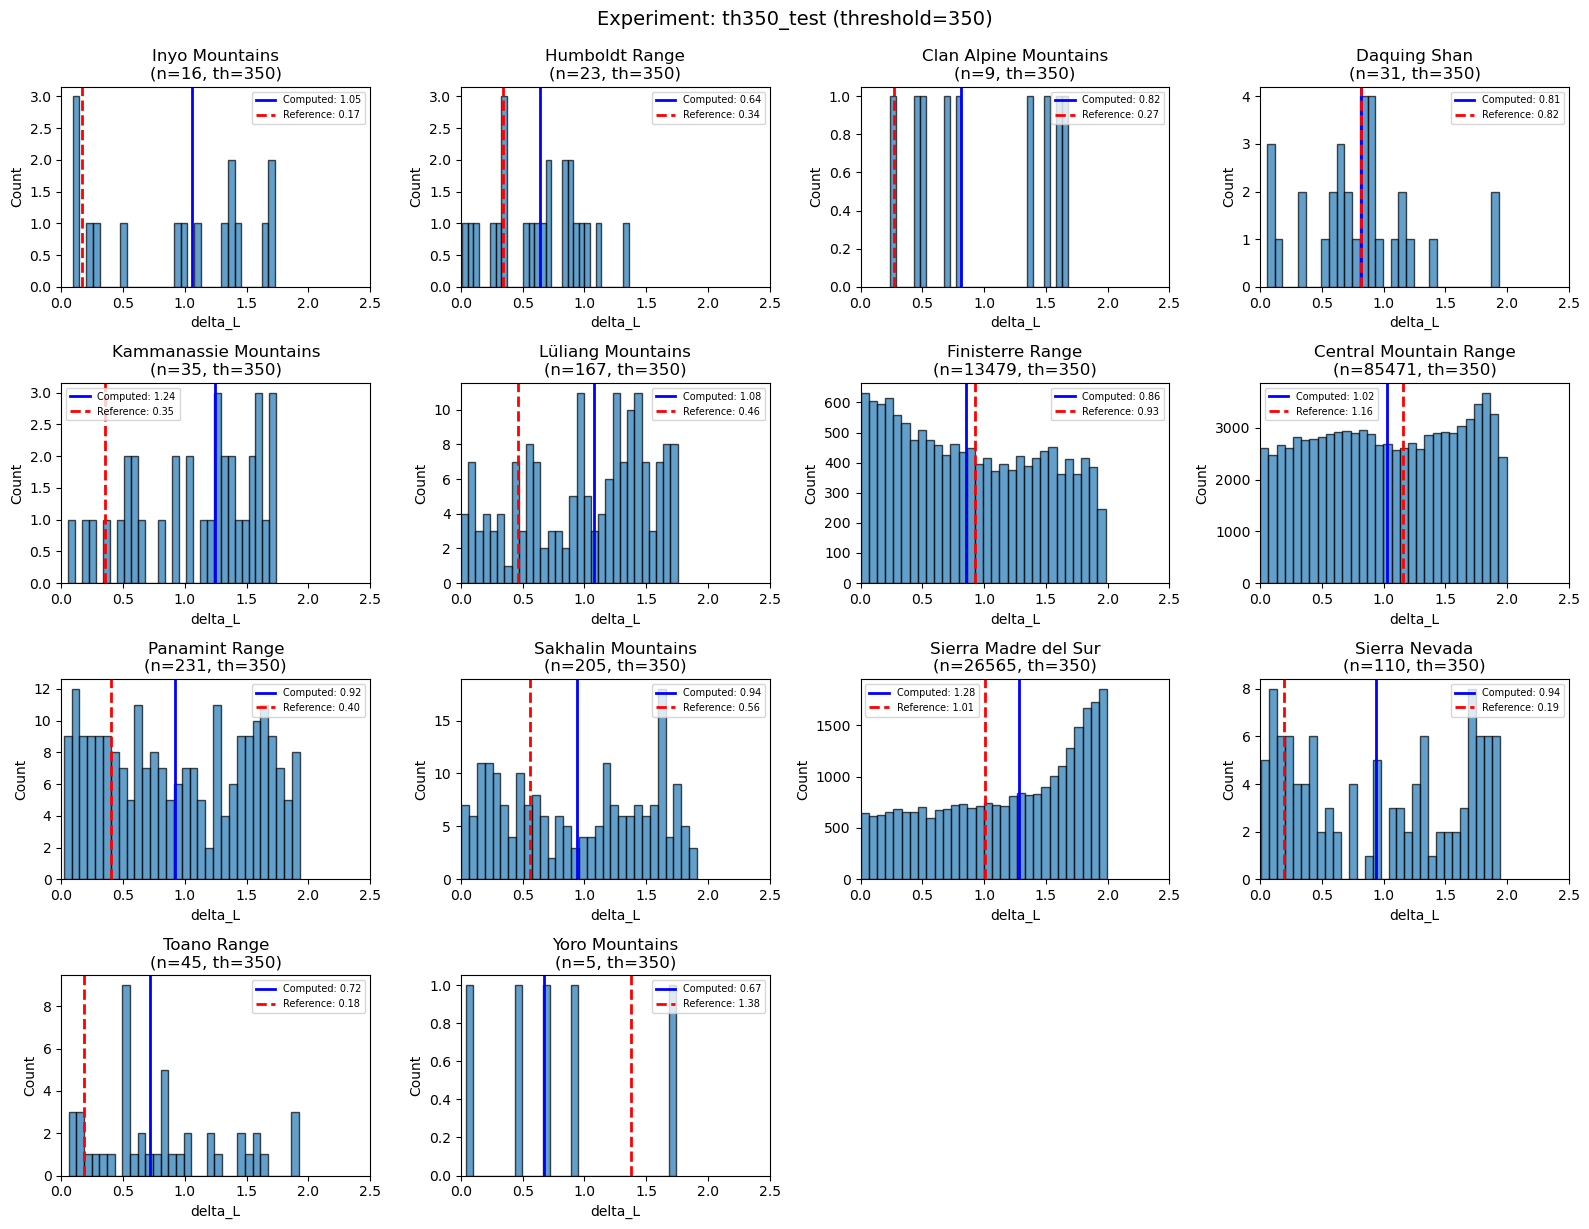

In [8]:
# Plot delta_L distribution for analyzed basins
n_basins = len(basin_results)
if n_basins == 0:
    print("No results to plot")
else:
    n_cols = min(4, n_basins)
    n_rows = (n_basins + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    axes = np.atleast_1d(axes).flatten()
    
    for idx, (basin_name, df) in enumerate(basin_results.items()):
        ax = axes[idx]
        
        if df.empty:
            ax.set_title(f"{basin_name}: No data")
            continue
        
        config = get_basin_config(BASINS_TO_ANALYZE[basin_name]["paper_name"])
        ref = get_reference_delta_L(BASINS_TO_ANALYZE[basin_name]["paper_name"])
        
        delta_L = df['delta_L'].dropna()
        stats = compute_asymmetry_statistics(delta_L)
        
        ax.hist(delta_L, bins=30, alpha=0.7, edgecolor='black')
        ax.axvline(stats['median'], color='blue', linestyle='-', linewidth=2, 
                   label=f'Computed: {stats["median"]:.2f}')
        ax.axvline(ref['median'], color='red', linestyle='--', linewidth=2,
                   label=f'Reference: {ref["median"]:.2f}')
        
        ax.set_xlabel('delta_L')
        ax.set_ylabel('Count')
        short_name = config["full_name"].split(',')[0]
        ax.set_title(f"{short_name}\n(n={len(delta_L)}, th={STREAM_THRESHOLD})")
        ax.legend(fontsize=7)
        ax.set_xlim(0, 2.5)
    
    # Hide unused subplots
    for idx in range(len(basin_results), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle(f'Experiment: {EXPERIMENT_NAME} (threshold={STREAM_THRESHOLD})', y=1.02, fontsize=14)
    
    # Save figure
    fig.savefig(OUTPUT_DIR / "delta_L_distribution.png", dpi=150, bbox_inches='tight')
    print(f"Saved figure to: {OUTPUT_DIR / 'delta_L_distribution.png'}")
    plt.show()

---
## Export Combined Results

---
## Aridity Index vs. Delta-L

Saved figure to: /Users/guypi/Projects/channel-heads/data/outputs/experiments/th350_test/aridity_vs_delta_L.png


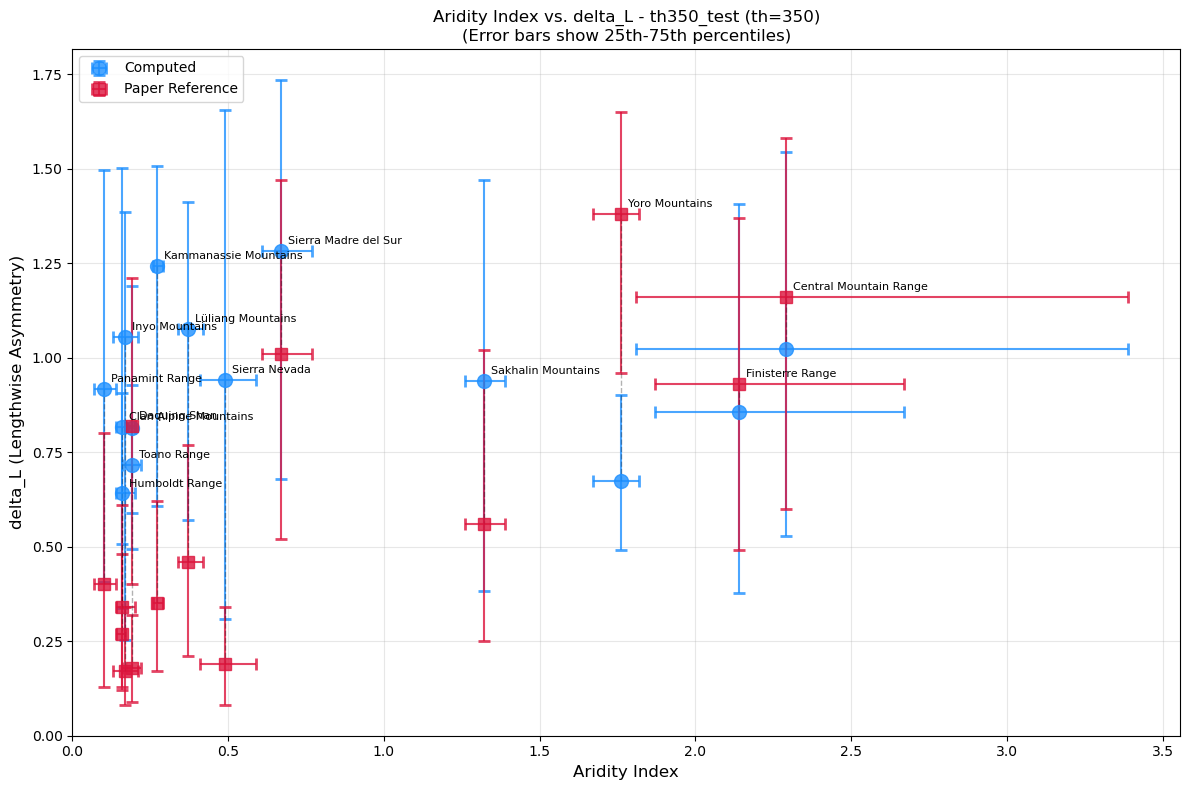

In [9]:
# Scatter plot: Aridity Index vs. Lengthwise Asymmetry (delta_L)
if len(basin_results) == 0:
    print("No results to plot")
else:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Collect data for all analyzed basins
    plot_data = []
    for basin_name, df in basin_results.items():
        if df.empty:
            continue
        
        config = get_basin_config(BASINS_TO_ANALYZE[basin_name]["paper_name"])
        ref = get_reference_delta_L(BASINS_TO_ANALYZE[basin_name]["paper_name"])
        stats = compute_asymmetry_statistics(df['delta_L'].dropna())
        
        plot_data.append({
            "name": config['full_name'].split(',')[0],
            "aridity": config["aridity_index"],
            "aridity_25": config["aridity_index_25"],
            "aridity_75": config["aridity_index_75"],
            "computed_median": stats['median'],
            "computed_25": stats['p25'],
            "computed_75": stats['p75'],
            "ref_median": ref['median'],
            "ref_25": ref['p25'],
            "ref_75": ref['p75'],
        })
    
    # Plot computed values (blue circles)
    for i, d in enumerate(plot_data):
        ax.errorbar(
            d["aridity"], d["computed_median"],
            xerr=[[d["aridity"] - d["aridity_25"]], [d["aridity_75"] - d["aridity"]]],
            yerr=[[d["computed_median"] - d["computed_25"]], [d["computed_75"] - d["computed_median"]]],
            fmt='o', markersize=10, capsize=4, capthick=2,
            color='dodgerblue', ecolor='dodgerblue', alpha=0.8,
            label='Computed' if i == 0 else None
        )
    
    # Plot reference values (red squares)
    for i, d in enumerate(plot_data):
        ax.errorbar(
            d["aridity"], d["ref_median"],
            xerr=[[d["aridity"] - d["aridity_25"]], [d["aridity_75"] - d["aridity"]]],
            yerr=[[d["ref_median"] - d["ref_25"]], [d["ref_75"] - d["ref_median"]]],
            fmt='s', markersize=8, capsize=4, capthick=2,
            color='crimson', ecolor='crimson', alpha=0.8,
            label='Paper Reference' if i == 0 else None
        )
    
    # Connect computed and reference with dashed lines
    for d in plot_data:
        ax.plot([d["aridity"], d["aridity"]], 
                [d["computed_median"], d["ref_median"]], 
                'k--', alpha=0.3, linewidth=1)
    
    # Add labels
    for d in plot_data:
        y_pos = max(d["computed_median"], d["ref_median"])
        ax.annotate(d["name"], (d["aridity"], y_pos),
                    textcoords="offset points", xytext=(5, 5), fontsize=8)
    
    ax.set_xlabel('Aridity Index', fontsize=12)
    ax.set_ylabel('delta_L (Lengthwise Asymmetry)', fontsize=12)
    ax.set_title(f'Aridity Index vs. delta_L - {EXPERIMENT_NAME} (th={STREAM_THRESHOLD})\n'
                 f'(Error bars show 25th-75th percentiles)', fontsize=12)
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    
    plt.tight_layout()
    fig.savefig(OUTPUT_DIR / "aridity_vs_delta_L.png", dpi=150, bbox_inches='tight')
    print(f"Saved figure to: {OUTPUT_DIR / 'aridity_vs_delta_L.png'}")
    plt.show()

In [10]:
# Combine all results
all_results = []
for basin_name, df in basin_results.items():
    if df.empty:
        continue
    df_copy = df.copy()
    df_copy['basin'] = basin_name
    config = get_basin_config(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    df_copy['basin_full_name'] = config['full_name']
    df_copy['stream_threshold'] = STREAM_THRESHOLD
    df_copy['experiment'] = EXPERIMENT_NAME
    all_results.append(df_copy)

if all_results:
    df_all = pd.concat(all_results, ignore_index=True)
    
    combined_path = OUTPUT_DIR / "all_basins_combined.csv"
    df_all.to_csv(combined_path, index=False)
    
    print(f"\nCombined results saved to: {combined_path}")
    print(f"Total pairs: {len(df_all)}")
    print(f"Total touching: {df_all['touching'].sum()}")
    print(f"Basins: {df_all['basin'].nunique()}")
else:
    print("No results to combine")


Combined results saved to: /Users/guypi/Projects/channel-heads/data/outputs/experiments/th350_test/all_basins_combined.csv
Total pairs: 126392
Total touching: 1952
Basins: 14


---
## Experiment Complete

Results have been saved to the experiment output directory. To compare with other experiments:

```python
# Load results from different experiments
import pandas as pd
from channel_heads import get_experiment_output_dir

df_th145 = pd.read_csv(get_experiment_output_dir("th145_baseline") / "all_basins_combined.csv")
df_th500 = pd.read_csv(get_experiment_output_dir("th500_test") / "all_basins_combined.csv")

# Compare delta_L distributions
print(f"Threshold 145: median delta_L = {df_th145['delta_L'].median():.3f}")
print(f"Threshold 500: median delta_L = {df_th500['delta_L'].median():.3f}")
```